## Set to use GPU instead of CPU (if available)

In [5]:
import torch

DEVICE = torch.device("cpu")                    # Default to CPU
if (torch.cuda.is_available()):                 # True if GPU is available
    print(torch.cuda.get_device_name(0))        # Should print your GPU name
    DEVICE = torch.device("cuda")

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")


NVIDIA GeForce RTX 2060
Using device: cuda
PyTorch version: 2.5.1
CUDA version: 12.4


## Data Pipeline

In [7]:
import musdb

# Ensure the path "musdb18hq" is correct
mus_test    = musdb.DB(root="musdb18hq", subsets="test", is_wav=True)
mus_train   = musdb.DB(root="musdb18hq", subsets="train", split='train', is_wav=True)
mus_valid   = musdb.DB(root="musdb18hq", subsets="train", split='valid', is_wav=True)

print(f"Number of tracks in musdb: {len(mus_test.tracks) + len(mus_train.tracks) + len(mus_valid.tracks)}")
print(f"Number of tracks in musdb_test: {len(mus_test.tracks)}")
print(f"Number of tracks in musdb_train: {len(mus_train.tracks)}")
print(f"Number of tracks in musdb_valid: {len(mus_valid.tracks)}")

Number of tracks in musdb: 150
Number of tracks in musdb_test: 50
Number of tracks in musdb_train: 86
Number of tracks in musdb_valid: 14


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import librosa

In [64]:
# Select a random chunk for testing
RANDOM_TRACKS = random.sample(mus_test.tracks, 25) # Increase the number of tracks to test, 50 gives us all of them
for t in RANDOM_TRACKS:
    t.chunk_duration = 10
    t.chunk_start = random.uniform(15, (t.duration - 30) - t.chunk_duration)

TRACK = RANDOM_TRACKS[0]  # Use the first track from the random selection
print(f"Track name: {TRACK.name}")
# Extract stereo audio slices
MIXTURE = TRACK.audio
VOCALS  = TRACK.targets['vocals'].audio
print(MIXTURE.shape, VOCALS.shape)

# Define the output directory for separated outputs
OUTPUT_DIR = "separated_outputs"

Track name: Enda Reilly - Cur An Long Ag Seol
(441000, 2) (441000, 2)


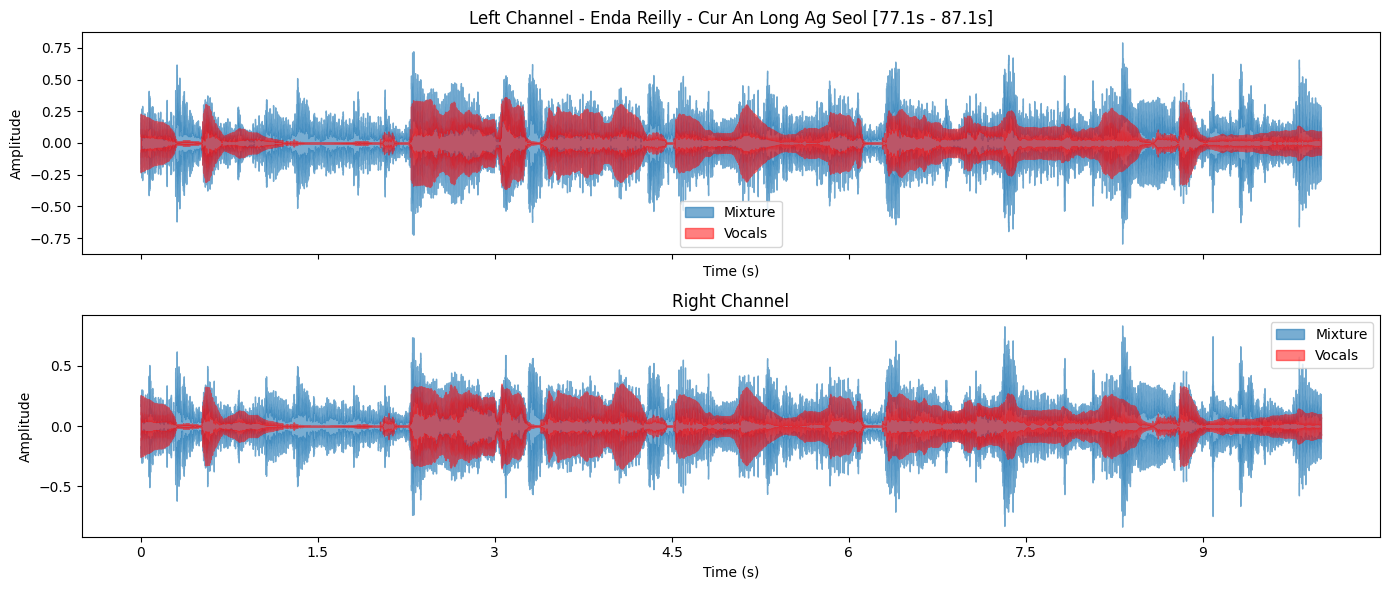

In [65]:
# Plot stereo channels separately
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Left channel
axs[0].set_title(f"Left Channel - {TRACK.name} [{TRACK.chunk_start:.1f}s - {TRACK.chunk_start + TRACK.chunk_duration:.1f}s]")
librosa.display.waveshow(MIXTURE[:, 0], sr=44100, alpha=0.6, label='Mixture', ax=axs[0])
librosa.display.waveshow(VOCALS[:, 0], sr=44100, alpha=0.5, color='r', label='Vocals', ax=axs[0])
axs[0].legend()
# Right channel
axs[1].set_title("Right Channel")
librosa.display.waveshow(MIXTURE[:, 1], sr=44100, alpha=0.6, label='Mixture', ax=axs[1])
librosa.display.waveshow(VOCALS[:, 1], sr=44100, alpha=0.5, color='r', label='Vocals', ax=axs[1])
axs[1].legend()

for ax in axs.flat:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


## Using pre-trained model - **Open-Unmix** 

The model *umxhq* from Open-Unmix was pre-trained on the same dataset we are using, so there's no relevant advantages we could get from fine tunning it.

In [69]:
from openunmix import predict

# Assuming `mixture` has shape (N, 2) for stereo audio and we need (2, N)
mixture_tensor = torch.from_numpy(np.transpose(MIXTURE)).float()

# Run separation
estimates = predict.separate(
    audio=mixture_tensor,
    rate=44100,
    model_str_or_path='umxhq',
    targets=['vocals'],
    residual=True, # Residual audio is the mixture minus the separated targets
    device=DEVICE
)

In [55]:
import soundfile as sf
import os
from museval import eval_mus_track, EvalStore
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
si_sdr = ScaleInvariantSignalDistortionRatio().to(DEVICE)

SI-SDR (Scale-Invariant Signal-to-Distortion Ratio) is a metric that measures the quality of source separation by comparing the predicted audio to the clean target audio.

🔍 What it measures:

- How similar your estimated signal is to the ground truth

- Ignoring differences in volume (scale-invariant)

- Higher dB values mean better separation (less distortion)

In [70]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
# Delete previous files
for file in os.listdir(OUTPUT_DIR):
    file_path = os.path.join(OUTPUT_DIR, file)
    if os.path.isfile(file_path):
        os.remove(file_path)

# Save the original mixture and expected vocals for comparison
sf.write(os.path.join(OUTPUT_DIR, f"{TRACK.name}_expected_mixture.wav"), MIXTURE, 44100)
sf.write(os.path.join(OUTPUT_DIR, f"{TRACK.name}_expected_vocals.wav"), VOCALS, 44100)

# For stereo audio torch tensors
exp_vocals = np.squeeze(    # (1, 2, N) -> (2, N)
    estimates.get('vocals')
    .detach().cpu().numpy() # torch.Size([1, 2, N]) -> (1, 2, N)
    ).T                     # (2, N) -> (N, 2)
exp_residual = np.squeeze(estimates.get('residual').detach().cpu().numpy()).T

# Save separated audio files
sf.write(os.path.join(OUTPUT_DIR, f"{TRACK.name}_predicted_vocals.wav"), exp_vocals, 44100)
sf.write(os.path.join(OUTPUT_DIR, f"{TRACK.name}_predicted_residual.wav"), exp_residual, 44100)

# Evaluate the separated audio
scores = eval_mus_track(TRACK, user_estimates={'vocals': exp_vocals,'accompaniment': exp_residual})
print(f"Scores for '{TRACK.name}':")
print(scores)

est = torch.tensor(exp_vocals, dtype=torch.float32).to(DEVICE)
target = torch.tensor(TRACK.targets['vocals'].audio, dtype=torch.float32).to(DEVICE)
# Trim target to match estimate
target = target[:est.shape[0]]

# Compute SI-SDR
si_sdr_score = si_sdr(est, target)
print(f"SI-SDR score: {si_sdr_score.item():.2f} dB")


Scores for 'Enda Reilly - Cur An Long Ag Seol':
vocals          ==> SDR:   9.100  SIR:  18.678  ISR:  12.906  SAR:   8.200  
accompaniment   ==> SDR:  13.603  SIR:  16.503  ISR:  23.902  SAR:  13.762  

SI-SDR score: 15.98 dB


Analyzing the metrics, we can see that a few are returned by the eval_mus_track function. It's important to note that, in all of them, a higher score is better.

Starting with the most important one, **SDR (Source to Distortion Ratio)**. This metric is considered to be an overall measure of separation quality, and measures the power ratio between the intended source and the distortion artefacts introduced during separation.

Next, we have **SIR (Source to Interference Ratio)**. This metric measures how well other unwanted sources were removed from the audio. We could consider this to be close to the concept of "leakage" of other sources.

Next, we move on to **SAR (Source to Artefacts Ratio)**. This metric measures how clean the generated separated audio is, in other words if it is free from the so-called artefacts (unwanted sounds or distortions that weren't present in the original audio).

Finally, we have **ISR (Image to Spatial Ratio)**. This metric diverges from the previous ones because it deals with the preservation of spatial characteristics in the separated audio.


In [50]:
results = EvalStore(frames_agg='median', tracks_agg='median')
si_sdr_scores = []

for t in RANDOM_TRACKS:
    print(f"Processing track: {t.name}")

    # Skip if vocals are all zeros (silent chunk)
    if np.allclose(t.targets['vocals'].audio, 0):
        print(f"Skipping {t.name}: vocals are silent in this chunk.")
        continue

    mixture_tensor = torch.from_numpy(np.transpose(t.audio)).float()
    estimates = predict.separate(
        audio=mixture_tensor,
        rate=44100,
        model_str_or_path='umxhq',
        targets=['vocals'],
        residual=True, # Residual audio is the mixture minus the separated targets
        device=DEVICE
    )

    exp_vocals = np.squeeze(estimates.get('vocals').detach().cpu().numpy()).T
    exp_residual = np.squeeze(estimates.get('residual').detach().cpu().numpy()).T
    scores = eval_mus_track(t, user_estimates={'vocals': exp_vocals,'accompaniment': exp_residual})
    results.add_track(scores)

    # median SI-SDR for the track
    est = torch.tensor(exp_vocals, dtype=torch.float32).to(DEVICE)
    target = torch.tensor(t.targets['vocals'].audio, dtype=torch.float32).to(DEVICE)
    # Trim target to match estimate
    target = target[:est.shape[0]]
    si_sdr_scores.append(si_sdr(est, target).item())

print(results)
print(f"Median SI-SDR score across all tracks: {np.median(si_sdr_scores):.2f} dB")

Processing track: Bobby Nobody - Stitch Up
Processing track: The Mountaineering Club - Mallory
Processing track: Sambasevam Shanmugam - Kaathaadi
Skipping Sambasevam Shanmugam - Kaathaadi: vocals are silent in this chunk.
Processing track: Triviul feat. The Fiend - Widow
Processing track: Motor Tapes - Shore
Processing track: Cristina Vane - So Easy
Processing track: We Fell From The Sky - Not You
Processing track: Nerve 9 - Pray For The Rain
Skipping Nerve 9 - Pray For The Rain: vocals are silent in this chunk.
Processing track: Carlos Gonzalez - A Place For Us
Processing track: The Sunshine Garcia Band - For I Am The Moon
Processing track: Mu - Too Bright
Processing track: Arise - Run Run Run
Processing track: Hollow Ground - Ill Fate
Processing track: The Long Wait - Dark Horses
Processing track: The Doppler Shift - Atrophy
Processing track: Skelpolu - Resurrection
Skipping Skelpolu - Resurrection: vocals are silent in this chunk.
Processing track: M.E.R.C. Music - Knockout
Processi

## Experimental Skeleton Code

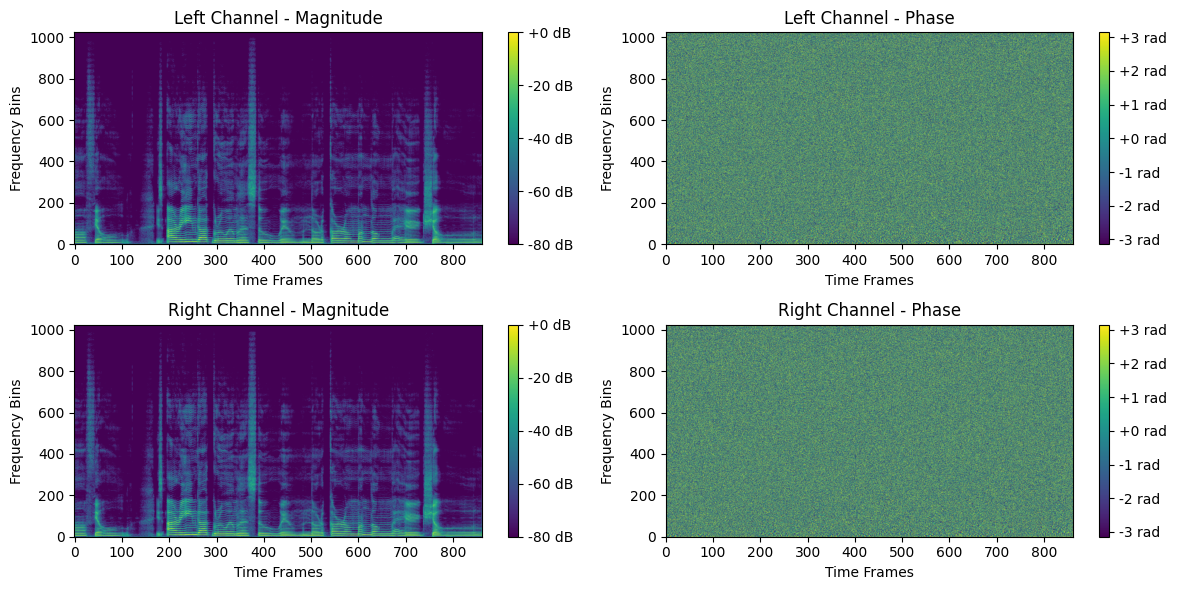

In [67]:
# Assume `vocals` is stereo: shape (N, 2)
left = VOCALS[:, 0]
right = VOCALS[:, 1]

# Compute STFT for each channel
spec_left = librosa.stft(left)
spec_right = librosa.stft(right)

# Compute magnitude and phase
mag_left, phase_left = np.abs(spec_left), np.angle(spec_left)
mag_right, phase_right = np.abs(spec_right), np.angle(spec_right)

# Plot magnitude and phase for both channels
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Left channel plots
axs[0, 0].set_title('Left Channel - Magnitude')
img0 = axs[0, 0].imshow(librosa.amplitude_to_db(mag_left, ref=np.max),
                        aspect='auto', origin='lower')
plt.colorbar(img0, ax=axs[0, 0], format='%+2.0f dB')
axs[0, 1].set_title('Left Channel - Phase')
img1 = axs[0, 1].imshow(phase_left, aspect='auto', origin='lower')
plt.colorbar(img1, ax=axs[0, 1], format='%+2.0f rad')

# Right channel plots
axs[1, 0].set_title('Right Channel - Magnitude')
img2 = axs[1, 0].imshow(librosa.amplitude_to_db(mag_right, ref=np.max),
                        aspect='auto', origin='lower')
plt.colorbar(img2, ax=axs[1, 0], format='%+2.0f dB')
axs[1, 1].set_title('Right Channel - Phase')
img3 = axs[1, 1].imshow(phase_right, aspect='auto', origin='lower')
plt.colorbar(img3, ax=axs[1, 1], format='%+2.0f rad')

for ax in axs.flat:
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Frequency Bins')

plt.tight_layout()
plt.show()


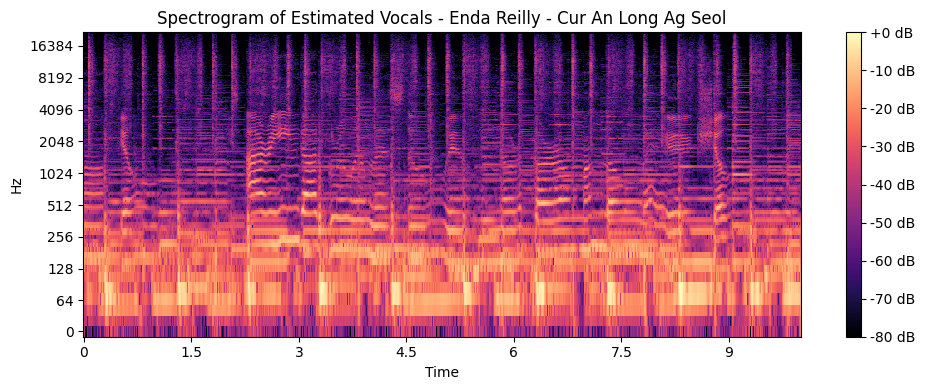

In [68]:
# plot the spectrogram of the mixture
spec_mixture = librosa.stft(MIXTURE[:, 0])  # Use one channel for the mixture
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec_mixture), ref=np.max),
                         sr=44100, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram of Estimated Vocals - {TRACK.name}')
plt.tight_layout()
plt.show()

As we can see, we separated the STFT into 2 separate components, the **Magnitude** (Left) and **Phase** (Right). \
The first one is easy to interpret, as it shows how strong each frequency is at each time, meaning that the yellow-ish frequencies probably represent the instruments of the music track while the blue areas are frequencies that are not listened at all. \
The second plot is much more complex to analyse, as it seems to noisy and nonsensical, but it is actually an **extremely important** feature of the audio track.


We can’t ignore the phase if we want to reconstruct high-quality waveforms, even though for source separation it's common to:
- Use just the magnitude for masking.
- Reuse the mixture’s phase for inverse STFT.
- Accept a quality trade-off unless we were using time domain models instead of time-frequency domain models.

Also, note that a **Stereo** audio, when compared to **Mono**, have 1 more channel, that usually is a duplication of the first, but could either have different volumes (value of dB) or even different Frequency Bins, meaning that it can create a better ilusion of 3D audio space but also separate the instruments of the track completetly. \
For that reason, we initially decided to use Mono samples because we thought that having a simpler model would be much faster to train and also give us better results, but that's only half true. \
Firstly, to convert from Stereo to Mono, we are basically doing a MEAN between the channels waveforms. That's great but it loses some properties from the original track, which is not good if we want to keep that high fidelity and quality of our *.wav* files. \
That is why, at the end we decided to work with Stereo, even though it costs more GPU resources.

## Training and Evaluating our Model

At the begining, we were using **CNN** with **Time domain model**, but later decided to change to **(Dual-Path) RNN**, as it is more suitable for this specific task of Audio Source Separation with conjuction to **Time-Frequency domain model**, which is in theory worse than the first model type but it can be lighter if we use a more complex NN like DPRNN.

### Preprocessing data and loading it

Each file generated by this next code cell is a stereo log-magnitude spectrogram with shape (2, freq_bins, time_frames).

By default the chunks are 6s long. If the track length is not divisible by the size of each chunk, then there will be some unprocessed chunks left at the end of the track, which is fine as usually those last 5 seconds the singer does not sing at all.

It took about 15 minutes and the size of *data* folder is 44.7GB (bigger than original *musdb18hq*)

| Term             | Description                                      | Formula         |
| ---------------- | ------------------------------------------------ | -------------- |
| `frequency_bins` | How many frequency bands (height of spectrogram) | frequency_bins = n_fft // 2 + 1 |
| `time_frames`    | How many time steps across the audio (width)     | time_frames = (audio_length - window_size) // hop_size + 1 |


In [17]:
import src.dataloader as dt

# Ignore this cell if folder "data" already exists
if not os.path.exists('data'):
    i = 1
    # Preprocess the dataset
    for split, dataset in zip(['train', 'valid'], [mus_train, mus_valid]):
        for t in dataset.tracks:
            dt.preprocess_track(t, save_dir='data', split=split)
            if i % 10 == 0:
                print(f"Processed {i}/100 tracks!")
            i += 1


"For the recurrent network, we use data augmentation during training and show that even simple separation networks are prone to over-fitting if no data augmentation is used. [...] We show that data augmentation helps to learn separating networks that generalize better."

https://ieeexplore.ieee.org/document/7952158

In [18]:
from torch.utils.data import DataLoader

train_dataset = dt.STFTChunkDataset(split='train', augment=True)
valid_dataset = dt.STFTChunkDataset(split='valid')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

# Sanity check
X_batch, Y_batch, X_phase = next(iter(train_loader)) # mixture, vocals
print(X_batch.shape)  # (B, 2, freq_bins, time_frames) # 8 [2 [1025 [259]]]
print(Y_batch.shape)  # (B, 2, freq_bins, time_frames) # 8 [2 [1025 [259]]]
print(X_phase.shape)  # (B, 2, freq_bins, time_frames) # 8 [2 [1025 [259]]]


Loaded 3157 files from:
- train/mixture
- train/vocals
- train/phase
Loaded 611 files from:
- valid/mixture
- valid/vocals
- valid/phase
torch.Size([8, 2, 1025, 259])
torch.Size([8, 2, 1025, 259])
torch.Size([8, 2, 1025, 259])


- The batch size is 8 samples
- Each sample is a 6-second stereo spectrogram chunk

    - 8: batch size
    - 2: stereo channels (L/R)
    - 1025: frequency bins → expected for n_fft=2048 (n_fft // 2 + 1)
    - 259: time frames → for a 6-second chunk at hop length 1024, this is spot-on

### Building and training our model

DPRNN divides the input spectrogram into overlapping chunks along the time axis, and applies two recurrent layers:

    Intra-chunk RNN
- models local structure within each chunk

---

    Inter-chunk RNN
- models global dependencies across chunks

This structure allows effective modeling of long-range temporal dependencies with reduced memory.

| Term              | Meaning                                                                                                   |
| ----------------- | --------------------------------------------------------------------------------------------------------- |
| **Causal SS**     | The model only uses **past and current frames** to predict the output at time `t`. It doesn’t look ahead. |
| **Non-Causal SS** | The model uses **past, current, and future frames** to predict the output at time `t`.                    |

Imagine we're trying to separate a singer's voice from a mix:

- Causal SS: We're listening to the audio in **real-time** and must decide right now who's singing — we only know what we've heard so far.
- Non-Causal SS: We're listening to the full song with the ability to scrub forward/back — so we can make a more accurate decision using the future.

In our case, we will train based on *Non-Causal SS*, which is why we can use **Bidirectional** or **Dual Path** RNN (we decided to use DPRNN as it is much more powerful than the first).

* **BiRNN** (e.g., BiLSTM) processes a sequence **once** in both directions.
* **DPRNN** uses **two RNNs**:

  * One **inside** each chunk (intra-RNN)
  * One **across** chunks (inter-RNN)

So, **DPRNN = dual RNN passes + chunking** → it's more powerful than a plain BiRNN.


In [19]:
import torch.nn as nn
import torch.nn.functional as Ft
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime

https://arxiv.org/pdf/1910.06379

We decided to implement the DPRNN Block class as we noticed a high decrease in loss, as discussed in this paper.

In [20]:
class DPRNNBlock(nn.Module):
    def __init__(self, input_dim, hidden, chunk_size, hop_size):
        super(DPRNNBlock, self).__init__()
        self.chunk_size = chunk_size
        self.hop_size = hop_size
        self.hidden = hidden

        self.intra_rnn = nn.LSTM(input_dim, hidden, batch_first=True, bidirectional=True)
        self.intra_linear = nn.Linear(2 * hidden, input_dim)
        self.intra_norm = nn.LayerNorm(input_dim)

        self.inter_rnn = nn.LSTM(input_dim, hidden, batch_first=True, bidirectional=True)
        self.inter_linear = nn.Linear(2 * hidden, input_dim)
        self.inter_norm = nn.LayerNorm(input_dim)

    def forward(self, xi):
        # xi: (B, F, T)
        B, F, T = xi.shape

        # Segment into overlapping chunks
        xi_unfold = xi.unfold(dimension=2, size=self.chunk_size, step=self.hop_size)  # (B, F, n_chunks, chunk_size)
        n_chunks = xi_unfold.shape[2]

        # Intra-chunk RNN (within each chunk)
        intra_in = xi_unfold.permute(0, 2, 3, 1).contiguous().view(B * n_chunks, self.chunk_size, F)
        intra_out, _ = self.intra_rnn(intra_in)
        intra_out = self.intra_linear(intra_out)
        intra_out = self.intra_norm(intra_out + intra_in)
        intra_out = intra_out.view(B, n_chunks, self.chunk_size, F).permute(0, 3, 2, 1)  # (B, F, chunk_size, n_chunks)

        # Inter-chunk RNN (across chunks)
        inter_in = intra_out.permute(0, 2, 3, 1).contiguous().view(B * self.chunk_size, n_chunks, F)
        inter_out, _ = self.inter_rnn(inter_in)
        inter_out = self.inter_linear(inter_out)
        inter_out = self.inter_norm(inter_out + inter_in)
        inter_out = inter_out.view(B, self.chunk_size, n_chunks, F).permute(0, 3, 2, 1)  # (B, F, n_chunks, chunk_size)

        # Overlap-add reconstruction
        xi_reconstructed = self.overlap_add(inter_out, T)  # (B, F, T)
        return xi_reconstructed

    def overlap_add(self, chunks, T):
        # chunks: (B, F, n_chunks, chunk_size)
        B, F, n_chunks, _ = chunks.shape
        output = torch.zeros(B, F, T, device=chunks.device) # (B, F, T)
        count = torch.zeros(B, F, T, device=chunks.device) # (B, F, T)
        for i in range(n_chunks):
            start = i * self.hop_size
            end = start + self.chunk_size
            output[:, :, start:end] += chunks[:, :, i, :] # (B, F, chunk[i], chunk_size)
            count[:, :, start:end] += 1
        return output / (count + 1e-8)

The `overlap_add` function reconstructs a full-length time sequence from overlapping chunks processed by the DPRNN model. After splitting the input into overlapping segments and independently processing them, this function **stitches them back together** using an overlap-and-add method.

It works by:

* **Summing** the values from each chunk into their correct positions in the output,
* **Counting** how many values contribute to each time point,
* **Averaging** overlapping regions to ensure smoothness and correct scale.

DPRNN processes short, overlapping chunks for local context modeling. After that, the original time resolution must be restored for further steps like mask prediction or waveform reconstruction.

Example:

For a 1D signal `[1, 2, 3, 4, 5, 6, 7, 8]`, using `chunk_size=4` and `hop_size=2`:

* Chunks:
  `[1, 2, 3, 4]`
  `[3, 4, 5, 6]`
  `[5, 6, 7, 8]`

Overlapping regions like `[3, 4]` and `[5, 6]` will be added twice — so the final output must **divide those positions by 2** to average them properly.

This ensures the reassembled output matches the original signal length and maintains smooth transitions.


In [21]:
class DPRNNSeparator(nn.Module):
    def __init__(self, input_dim=1025, hidden=128, chunk_size=159, hop_size=100, num_blocks=2):
        super(DPRNNSeparator, self).__init__()
        self.chunk_size = chunk_size
        self.hop_size = hop_size

        self.dprnn_blocks = nn.ModuleList([
            DPRNNBlock(input_dim, hidden, chunk_size, hop_size)
            for _ in range(num_blocks)
        ])

         # Mask prediction head: outputs one mask per input channel (vocal mask)
        self.mask_out = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, C, _, _ = x.shape # x: (B, 2, F, T)
        mask_list = []

        for c in range(C):
            xi = x[:, c]  # (B, F, T)

            # Pass through each DPRNN block
            for block in self.dprnn_blocks:
                xi = block(xi)  # Still (B, F, T)

            mask_list.append(xi.unsqueeze(1))  # (B, 1, F, T)

        mask = torch.cat(mask_list, dim=1)  # (B, 2, F, T)
        mask = self.mask_out(mask)          # (B, 2, F, T) in [0, 1]

        vocal = x * mask                    # Predicted vocals
        accompaniment = x - vocal           # Residual (accompaniment)

        return vocal, accompaniment


https://arxiv.org/pdf/2202.07968

From the link above, we read that usually L1_freq and L2_freq (MSE_freq) losses are great options for audio source separation on time-frequency (or spectogram form) tasks! The main difference between both is that L2 is more sensitive to outliers than L1.

In [ ]:
def log_l2_freq_loss(pred_log_mag, target_log_mag):
    return Ft.mse_loss(pred_log_mag, target_log_mag)

def phase_aware_mse_loss(pred_mag, target_mag, mix_phase):
    """
    pred_mag: (B, 2, F, T) - predicted log-mag
    target_mag: (B, 2, F, T) - true log-mag
    mix_phase: (B, 2, F, T) - phase angle of mixture (radians)
    """
    # Recover magnitude from log
    pred_mag_lin = torch.expm1(pred_mag)
    target_mag_lin = torch.expm1(target_mag)

    # Reconstruct complex spectrograms
    pred_real = pred_mag_lin * torch.cos(mix_phase)
    pred_imag = pred_mag_lin * torch.sin(mix_phase)

    target_real = target_mag_lin * torch.cos(mix_phase)
    target_imag = target_mag_lin * torch.sin(mix_phase)

    # Compute MSE in complex domain
    loss_real = Ft.mse_loss(pred_real, target_real)
    loss_imag = Ft.mse_loss(pred_imag, target_imag)

    return loss_real + loss_imag

def train_dprnn(model, train_loader, valid_loader, device=DEVICE, num_epochs=20, lr=1e-3, alpha=0.1):
    model = model.to(device)
    criterion = log_l2_freq_loss  # Use LOGL2freq loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # TensorBoard logging
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    writer = SummaryWriter(logdir)

    # Early stopping
    best_valid_loss = float('inf')
    patience = num_epochs // 4 # 1/4 of total epochs
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for X, Y, train_phase in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            X, Y, train_phase = X.to(device), Y.to(device), train_phase.to(device)
            optimizer.zero_grad()
            Y_pred, _ = model(X)  # predicted log-magnitude vocal spectrogram
            loss = criterion(Y_pred, Y) + alpha * phase_aware_mse_loss(Y_pred, Y, train_phase)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0) # accumulate loss over the batch (X.size(0) is the batch size)

        train_loss /= len(train_loader.dataset) # average loss over the entire dataset (3157 chunks of 6s)

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X_val, Y_val, val_phase in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
                X_val, Y_val, val_phase = X_val.to(device), Y_val.to(device), val_phase.to(device)
                Y_pred, _ = model(X_val)
                loss = criterion(Y_pred, Y_val) + alpha * phase_aware_mse_loss(Y_pred, Y_val, val_phase)

                valid_loss += loss.item() * X_val.size(0) # accumulate loss over the batch (X_val.size(0) is the batch size)

        valid_loss /= len(valid_loader.dataset) # average loss over the entire dataset (611 chunks of 6s)

        # Log to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", valid_loss, epoch)
        writer.flush()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.5f} | Valid Loss: {valid_loss:.5f}")

        # Early stopping check
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch+1} with best valid loss: {best_valid_loss:.5f}")
                break

    writer.close()

    if best_model_state:
        model.load_state_dict(best_model_state)


A trained DPRNN model that takes log-magnitude spectrograms (from stereo mixture):
1. Load a stereo WAV test file (mixture).
2. Get its STFT and extract:
    - Log-magnitude input for model
    - Phase for later reconstruction

3. Run the model on log-magnitude.
4. Get predicted log-magnitude of vocals (target).
5. Reconstruct estimated waveform using original phase.
6. Save as .wav.

In [ ]:
model = DPRNNSeparator()
train_dprnn(model, train_loader, valid_loader)
# Save the model
torch.save(model.state_dict(), 'dprnn_ass.pt')


### Evaluating our model

Finally, we used our trained model to generate a separated version of the test track and compared the results with those produced by the Open-Unmix model.

In conclusion, although we acknowledge that a time-domain approach might have yielded better separation performance, we intentionally chose to work in the time-frequency (TF) domain for several key reasons:

* It allowed for a direct and fair comparison with Open-Unmix, which also operates in the TF domain.
* Models in the TF domain are generally lighter and faster to train and run, which aligned better with our resource constraints.
* Most importantly, it gave us the opportunity to deepen our understanding of the classic source separation pipeline.

While we leveraged advanced components—such as using a DPRNN architecture and implementing loss functions informed by recent literature—we still developed the model from the ground up. This hands-on process was highly educational and provided us with a solid foundation in both the theoretical and practical aspects of audio source separation.


In [ ]:
def separate_track_with_model(track, model, device=DEVICE, n_fft=2048, hop_length=1024):
    """
    Given a musdb track, run the trained model to separate vocals and accompaniment.
    Returns (exp_vocals, exp_residual) as stereo numpy arrays.
    """
    # 1. Compute STFT for each channel
    mix_stft = [librosa.stft(track.audio.T[ch], n_fft=n_fft, hop_length=hop_length) for ch in range(2)]
    mix_mag = np.stack([np.log1p(np.abs(stft)) for stft in mix_stft])  # (2, F, T)
    mix_phase = np.stack([np.angle(stft) for stft in mix_stft])        # (2, F, T)

    # 2. Run model on log-magnitude
    mix_mag_tensor = torch.tensor(mix_mag, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 2, F, T)
    with torch.no_grad():
        pred_vocals, pred_residual = model(mix_mag_tensor)  # (1, 2, F, T)
        print(pred_vocals.shape, mix_mag_tensor.shape, mix_mag.shape)
        est_log_mag_vocals = pred_vocals.squeeze(0).cpu().numpy()  # (2, F, T)
        est_log_mag_residual = pred_residual.squeeze(0).cpu().numpy()  # (2, F, T)

    # 3. Convert back from log-magnitude to magnitude
    est_mag_vocals = np.expm1(est_log_mag_vocals)
    est_mag_residual = np.expm1(est_log_mag_residual)

    # 4. Combine magnitude with original phase
    est_stft_vocals = est_mag_vocals * np.exp(1j * mix_phase)
    est_stft_residual = est_mag_residual * np.exp(1j * mix_phase)

    # 5. iSTFT per channel
    estimated_audio_vocals = [librosa.istft(est_stft_vocals[ch], hop_length=hop_length) for ch in range(2)]
    estimated_audio_residual = [librosa.istft(est_stft_residual[ch], hop_length=hop_length) for ch in range(2)]

    # 6. Stack into stereo
    exp_vocals = np.stack(estimated_audio_vocals).T  # (N, 2)
    exp_residual = np.stack(estimated_audio_residual).T  # (N, 2)
    return exp_vocals, exp_residual

In [ ]:
def separate_and_save(model):
    """
    Run inference on a stereo mixture audio file using a trained model
    and reconstruct the estimated vocals waveform.
    """

    # 1. Select a test track
    print(f"Processing: {TRACK.name}")

    # 2. Save original mixture and expected vocals for comparison
    exp_vocals, exp_residual = separate_track_with_model(TRACK, model)

    output_path = f"{OUTPUT_DIR}/{TRACK.name}_OUR_vocals.wav"
    sf.write(output_path, exp_vocals, samplerate=TRACK.rate)
    print(f"Saved estimated vocals to: {output_path}")

    output_path = output_path.replace("vocals", "residual")
    sf.write(output_path, exp_residual, samplerate=TRACK.rate)
    print(f"Saved estimated residual to: {output_path}")

    scores = eval_mus_track(TRACK, user_estimates={'vocals': exp_vocals,'accompaniment': exp_residual})
    print(f"Scores for '{TRACK.name}':")
    print(scores)

    est = torch.tensor(exp_vocals, dtype=torch.float32).to(DEVICE)
    target = torch.tensor(TRACK.targets['vocals'].audio, dtype=torch.float32).to(DEVICE)
    # Trim target to match estimate
    target = target[:est.shape[0]]

    # Compute SI-SDR
    si_sdr_score = si_sdr(est, target)
    print(f"SI-SDR score: {si_sdr_score.item():.2f} dB")

    # plot the estimated vocals spectrogram
    est_vocals_stft = librosa.stft(exp_vocals[:, 0], n_fft=2048, hop_length=1024)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(est_vocals_stft), ref=np.max),
                             sr=TRACK.rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of Estimated Vocals - {TRACK.name}')
    plt.tight_layout()
    plt.show()


| Feature             | Time-Frequency Domain | Time-Domain                    |
| ------------------- | --------------------- | ------------------------------ |
| Input/Output        | Spectrogram           | Raw waveform                   |
| Phase Handling      | Hard (often reused)   | Not needed                     |
| Model Complexity    | Lower                 | Higher                         |
| Audio Quality       | Good                  | Excellent (if well-trained)    |
| Compute Requirement | Lower                 | Higher                         |
| Training Difficulty | Easier                | Harder                         |
| Real-Time Use       | Some latency (STFT)   | Lower latency possible         |
| Example Models      | Open-Unmix, Spleeter  | Demucs, Conv-TasNet (original) |


Processing: Enda Reilly - Cur An Long Ag Seol
torch.Size([1, 2, 1025, 429]) torch.Size([1, 2, 1025, 429]) (2, 1025, 429)
Saved estimated vocals to: separated_outputs/Enda Reilly - Cur An Long Ag Seol_OUR_vocals.wav
Saved estimated residual to: separated_outputs/Enda Reilly - Cur An Long Ag Seol_OUR_residual.wav
Scores for 'Enda Reilly - Cur An Long Ag Seol':
vocals          ==> SDR:   3.513  SIR:  40.162  ISR: -40.526  SAR:   0.000  
accompaniment   ==> SDR:   4.984  SIR: -30.079  ISR:   2.503  SAR:   0.001  

SI-SDR score: 11.90 dB


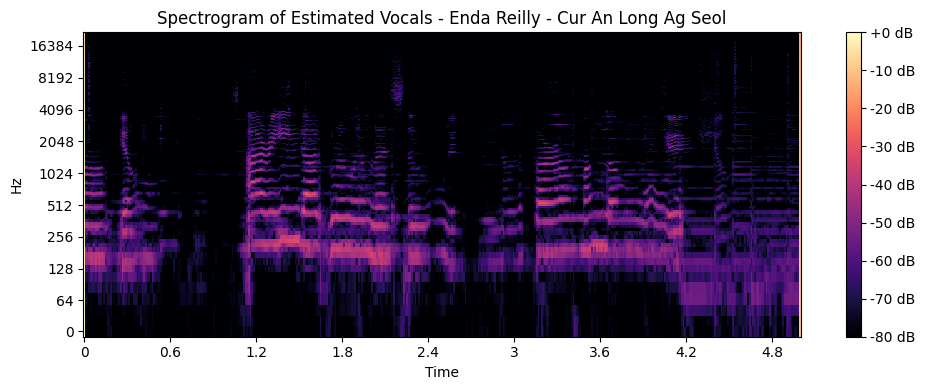

In [71]:
model = DPRNNSeparator()  # load your trained model
model.load_state_dict(torch.load("dprnn_ass.pt", weights_only=False))
model.eval().to(DEVICE)
separate_and_save(model)


In [51]:
results = EvalStore(frames_agg='median', tracks_agg='median')
si_sdr_scores = []

for t in RANDOM_TRACKS:
    print(f"Processing track: {t.name}")

    # Skip if vocals are all zeros (silent chunk)
    if np.allclose(t.targets['vocals'].audio, 0):
        print(f"Skipping {t.name}: vocals are silent in this chunk.")
        continue

    exp_vocals, exp_residual = separate_track_with_model(t, model)

    # Evaluate
    scores = eval_mus_track(
        t,
        user_estimates={'vocals': exp_vocals, 'accompaniment': exp_residual}
    )
    results.add_track(scores)

    # median SI-SDR for the track
    est = torch.tensor(exp_vocals, dtype=torch.float32).to(DEVICE)
    target = torch.tensor(t.targets['vocals'].audio, dtype=torch.float32).to(DEVICE)
    # Trim target to match estimate
    target = target[:est.shape[0]]
    si_sdr_scores.append(si_sdr(est, target).item())

print(results)
print(f"Median SI-SDR score across all tracks: {np.median(si_sdr_scores):.2f} dB")

Processing track: Bobby Nobody - Stitch Up
torch.Size([1, 2, 1025, 429]) torch.Size([1, 2, 1025, 429]) (2, 1025, 429)
Processing track: The Mountaineering Club - Mallory
torch.Size([1, 2, 1025, 429]) torch.Size([1, 2, 1025, 429]) (2, 1025, 429)
Processing track: Sambasevam Shanmugam - Kaathaadi
Skipping Sambasevam Shanmugam - Kaathaadi: vocals are silent in this chunk.
Processing track: Triviul feat. The Fiend - Widow
torch.Size([1, 2, 1025, 429]) torch.Size([1, 2, 1025, 429]) (2, 1025, 429)
Processing track: Motor Tapes - Shore
torch.Size([1, 2, 1025, 429]) torch.Size([1, 2, 1025, 429]) (2, 1025, 429)
Processing track: Cristina Vane - So Easy
torch.Size([1, 2, 1025, 429]) torch.Size([1, 2, 1025, 429]) (2, 1025, 429)
Processing track: We Fell From The Sky - Not You
torch.Size([1, 2, 1025, 429]) torch.Size([1, 2, 1025, 429]) (2, 1025, 429)
Processing track: Nerve 9 - Pray For The Rain
Skipping Nerve 9 - Pray For The Rain: vocals are silent in this chunk.
Processing track: Carlos Gonzale

## Using TensorBoard to compare previous tests

This next cell will generate a new TensorBoard instance and automatically open it on a new web browser tab!

In [22]:
import subprocess
import webbrowser
import time
import socket

# Start new TensorBoard silently to ignore cell output
subprocess.Popen(["tensorboard", "--logdir=logs", "--host=localhost", "--port=6006"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Wait until the server is ready
def wait_for_port(host, port, timeout=45):
    start_time = time.time()
    while True:
        try:
            with socket.create_connection((host, port), timeout=1):
                return True
        except OSError:
            time.sleep(0.5)
            if time.time() - start_time > timeout:
                return False

if wait_for_port('localhost', 6006):
    webbrowser.open("http://localhost:6006")
else:
    print("TensorBoard did not start within 45 seconds.")


**IMPORTANT:** DO NOT FORGET TO CLICK *RESTART KERNEL* TO CLOSE THE TENSORBOARD INSTANCE!

## Generating QRCode

In [8]:
import qrcode

if not os.path.exists("github_qr.png"):
    url = "https://ulisboa-my.sharepoint.com/:f:/g/personal/fc58176_alunos_fc_ul_pt/Eu8TBs_gbc5FnAd3MfTuNrsB2YEIrO9vH4yOkZbGzqU-8Q?e=a8RL4H"
    img = qrcode.make(url)
    img.save("github_qr.png")


## References

- Rafii, Zafar, Liutkus, Antoine, Stöter, Fabian-Robert, Mimilakis, Stylianos Ioannis, and Bittner, Rachel. (2019). **MUSDB18-HQ - an uncompressed version of MUSDB18**. https://doi.org/10.5281/zenodo.3338373

- Stöter, Fabian-Robert, Liutkus, Antoine, and Ito Nobutaka. (2018). The 2018 Signal Separation Evaluation Campaign. In Latent Variable Analysis and Signal Separation: 14th International Conference, LVA/ICA 2018, Surrey, UK, 293–305. https://doi.org/10.1007/978-3-319-77715-7_31

- [30+ Years of Source Separation Research: Achievements and Future Challenges](https://arxiv.org/pdf/2501.11837)

- [Benchmarks and leaderboards for sound demixing tasks](https://arxiv.org/pdf/2305.07489)

- [Open-Unmix GitHub](https://github.com/sigsep/open-unmix-pytorch)

- [Mono vs stereo - whats the difference and when does it matter](https://www.howtogeek.com/mono-vs-stereo-whats-the-difference-and-when-does-it-matter/)

- [Importance of phase spectrum in FF](https://math.stackexchange.com/questions/1290620/what-is-the-importance-of-phase-spectrum-in-fourier-transform)

- [Maximuum file path limitation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell#enable-long-paths-in-windows-10-version-1607-and-later)

- [How to calculate metrics SDR, SI-SDR, SIR and SAR](https://stackoverflow.com/questions/72939521/how-to-calculate-metrics-sdr-si-sdr-sir-sar-in-python)

- [Why use evaluation metrics instead of human reviews](https://source-separation.github.io/tutorial/basics/evaluation.html)

- [Scale-Invariant Source-to-Distortion Ratio - FORMULA](https://www.merl.com/publications/docs/TR2019-013.pdf)

- [Comparison of Losses in ASS](https://arxiv.org/pdf/2202.07968)

- [DUAL-PATH RNN: EFFICIENT LONG SEQUENCE MODELING FOR
TIME-DOMAIN SINGLE-CHANNEL SPEECH SEPARATION](https://arxiv.org/pdf/1910.06379)

- [Improving music source separation based on deep neural networks through data augmentation and network blending](https://ieeexplore.ieee.org/document/7952158)